<a href="https://www.kaggle.com/code/sharanharsoor/resnet50-transfer-learning-90-accuracy?scriptVersionId=122420137" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Transfer Learning.
Transfer learning for machine learning is when existing models are reused to solve a new challenge or problem. Transfer learning is not a distinct type of machine learning algorithm, instead it’s a technique or method used whilst training models. The knowledge developed from previous training is recycled to help perform a new task. The new task will be related in some way to the previously trained task, which could be to categorise objects in a specific file type. The original trained model usually requires a high level of generalisation to adapt to the new unseen data.

This notebook has the follwoing.
1. Importing libs.
2. Reading data and splitting train and test.
3. ResNet50 model Transfer Learning.
4. Fine tuning Transfer Learning model.


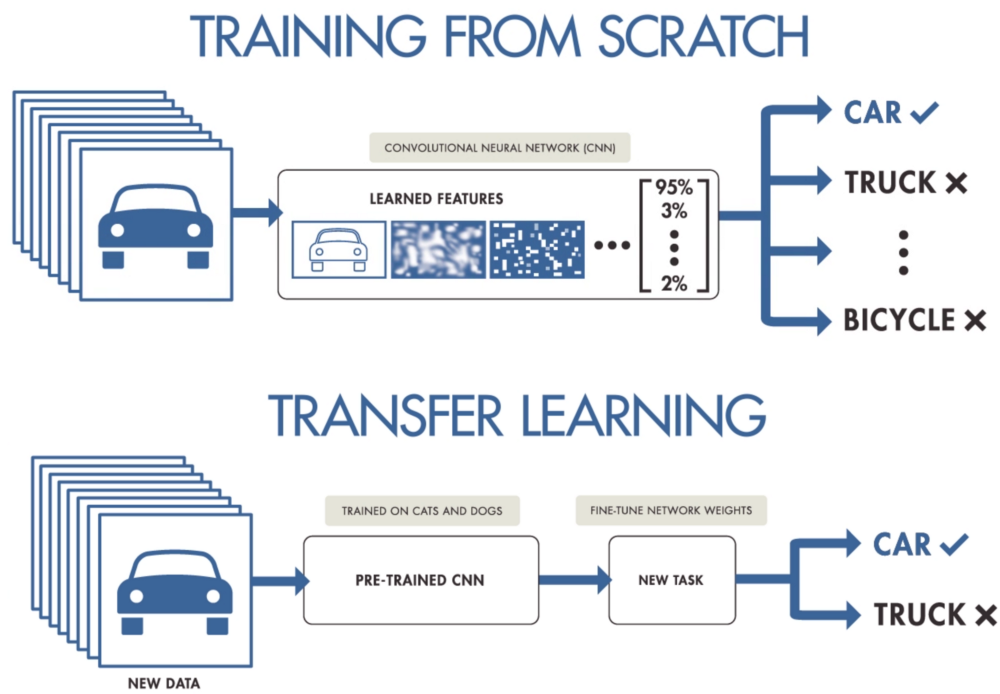



# 1. Importing libs.


In [1]:
import os
import shutil
import numpy as np
import glob   
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Input, Add,Dropout, Dense, Activation, ZeroPadding2D, \
BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import  plot_model
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from datetime import datetime 

from IPython.display import SVG
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

# 2. Reading data and splitting train and test.


In [2]:
# Where all dataset is there
data_dir = '/kaggle/input/flowers-recognition/flowers/'

# Training data dir
training_dir = '/kaggle/working/Train'

# Test data dir
testing_dir = '/kaggle/working/Test'

# Ratio of training and testing data
train_test_ratio = 0.8 

def split_dataset_into_test_and_train_sets(all_data_dir = data_dir, training_data_dir = training_dir, \
                                           testing_data_dir=testing_dir, train_test_ratio = 0.8):
    # Recreate testing and training directories
    
    if not os.path.exists(training_data_dir):
            os.mkdir(training_data_dir)

    if not os.path.exists(testing_data_dir):
            os.mkdir(testing_data_dir)               
    
    num_training_files = 0
    num_testing_files = 0


    for subdir, dirs, files in os.walk(all_data_dir):
        
        category_name = os.path.basename(subdir)
        
        # print(category_name + " vs " + os.path.basename(all_data_dir))
        if category_name == os.path.basename(all_data_dir):
              continue

        training_data_category_dir = training_data_dir + '/' + category_name
        testing_data_category_dir = testing_data_dir + '/' + category_name
        
        # creating subdir for each sub category
        if not os.path.exists(training_data_category_dir):
            os.mkdir(training_data_category_dir)   

        if not os.path.exists(testing_data_category_dir):
            os.mkdir(testing_data_category_dir)
            
        file_list = glob.glob(os.path.join(subdir,'*.jpg'))

        #print(os.path.join(all_data_dir, subdir))
        print(str(category_name) + ' has ' + str(len(files)) + ' images') 
        random_set = np.random.permutation((file_list))
        # copy percentage of data from each category to train and test directory
        train_list = random_set[:round(len(random_set)*(train_test_ratio))] 
        test_list = random_set[-round(len(random_set)*(1-train_test_ratio)):]

  

        for lists in train_list : 
            shutil.copy(lists, training_data_dir + '/' + category_name + '/' )
            num_training_files += 1
  
        for lists in test_list : 
            shutil.copy(lists, testing_data_dir + '/' + category_name + '/' )
            num_testing_files += 1
  

    print("Processed " + str(num_training_files) + " training files.")
    print("Processed " + str(num_testing_files) + " testing files.")

In [3]:
split_dataset_into_test_and_train_sets()

dandelion has 1052 images
daisy has 764 images
sunflower has 733 images
tulip has 984 images
rose has 784 images
Processed 3453 training files.
Processed 864 testing files.


# 3. ResNet50 model Transfer Learning.


In [4]:
# Number of classes in dataset
num_classes = 5

def get_model():
    # Get base model 
    # Here we are using ResNet50 as base model
    base_model = ResNet50(weights='imagenet', include_top=False)
    
    # As we are using ResNet model only for feature extraction and not adjusting the weights
    # we freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
        
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Adding our own layer 
    x = GlobalAveragePooling2D()(base_model_ouput)
    # Adding fully connected layer
    x = Dense(512, activation='relu')(x)
    x = Dense(num_classes, activation='softmax', name='fcnew')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [5]:
# Get the model
model = get_model()
# Compile it
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
# Summary of model
model.summary()

94765736/94765736 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                             

In [6]:
# Defining the imagedatagenerator for train and test image for pre-processing
# We don't give horizonal_flip or other preprocessing for validation data generator

image_size = 224
batch_size = 64

train_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
valid_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
train_generator = train_data_gen.flow_from_directory(training_dir, (image_size,image_size), batch_size=batch_size, class_mode='categorical')
valid_generator = valid_data_gen.flow_from_directory(testing_dir, (image_size,image_size), batch_size=batch_size, class_mode='categorical')

Found 3453 images belonging to 5 classes.
Found 864 images belonging to 5 classes.


In [7]:
# Training the fully conncected layer for initial epochs
epochs = 5

# Training the model

model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.n//batch_size,
    epochs=epochs,
    verbose=1)

Epoch 1/5
53/53 [==============================] - 59s 969ms/step - loss: 0.7701 - accuracy: 0.7173 - val_loss: 0.4744 - val_accuracy: 0.8233
Epoch 2/5
53/53 [==============================] - 51s 959ms/step - loss: 0.4184 - accuracy: 0.8572 - val_loss: 0.3800 - val_accuracy: 0.8522
Epoch 3/5
53/53 [==============================] - 51s 965ms/step - loss: 0.3548 - accuracy: 0.8799 - val_loss: 0.3481 - val_accuracy: 0.8714
Epoch 4/5
53/53 [==============================] - 51s 965ms/step - loss: 0.3072 - accuracy: 0.8955 - val_loss: 0.3266 - val_accuracy: 0.8810
Epoch 5/5
53/53 [==============================] - 53s 994ms/step - loss: 0.2792 - accuracy: 0.9112 - val_loss: 0.3163 - val_accuracy: 0.8894


# 4. Fine tuning Transfer Learning model.

In [8]:
# More fine tuning the model
# Training the model after 150 layers
# Generally ResNet is good at extracting lower level features so we are not fine tuning initial layers
epochs = 10

split_at = 140
for layer in model.layers[:split_at]: layer.trainable = False
for layer in model.layers[split_at:]: layer.trainable = True
    
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Choosing lower learning rate for fine-tuning
# learning rate is generally 10-1000 times lower than normal learning rate, if we are fine tuning the initial layers
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.n//batch_size,
    epochs=epochs,
    verbose=1)

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
53/53 [==============================] - 57s 1s/step - loss: 0.3646 - accuracy: 0.8929 - val_loss: 0.3112 - val_accuracy: 0.9002
Epoch 2/10
53/53 [==============================] - 52s 987ms/step - loss: 0.2390 - accuracy: 0.9280 - val_loss: 0.2717 - val_accuracy: 0.9062
Epoch 3/10
53/53 [==============================] - 51s 969ms/step - loss: 0.1845 - accuracy: 0.9484 - val_loss: 0.2487 - val_accuracy: 0.9147
Epoch 4/10
53/53 [==============================] - 52s 985ms/step - loss: 0.1424 - accuracy: 0.9575 - val_loss: 0.2404 - val_accuracy: 0.9159
Epoch 5/10
53/53 [==============================] - 52s 983ms/step - loss: 0.1136 - accuracy: 0.9687 - val_loss: 0.2208 - val_accuracy: 0.9219
Epoch 6/10
53/53 [==============================] - 52s 979ms/step - loss: 0.0932 - accuracy: 0.9764 - val_loss: 0.2314 - val_accuracy: 0.9171
Epoch 7/10
53/53 [==============================] - 52s 972ms/step - loss: 0.0719 - accuracy: 0.9861 - val_loss: 0.2281 - val_accuracy: 0.9231
Ep

############################## END ##############################